In [28]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from pygam import GAM, s, LinearGAM
import pickle
import xgboost as xgb
from xgboost import XGBRegressor
from prophet import Prophet

In [29]:
df_train = pd.read_csv("../Daten/validation_data.csv")

In [30]:
df_train['Date and time'] = pd.to_datetime(df_train['Date and time'], format='mixed', dayfirst=True, errors='coerce')
df_train.set_index('Date and time', inplace=True)

In [31]:
df_val = pd.read_csv("../Daten/test_data.csv")

In [32]:
df_val['Date and time'] = pd.to_datetime(df_val['Date and time'], format='mixed', dayfirst=True, errors='coerce')
df_val.set_index('Date and time', inplace=True)

# ARIMA

In [33]:
auto_arima_model = auto_arima(df_train["Power (kW)"].iloc[-144:], seasonal=False, trace=True, suppress_warnings=True, stepwise=False, m=1)
p, d, q = auto_arima_model.order

print(auto_arima_model.summary)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1837.119, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1835.217, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1820.216, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1822.190, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1824.152, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1823.974, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1837.647, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1825.620, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1822.188, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1824.200, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1825.981, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1827.729, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1822.212, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1824.182, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1826.125, Time=0.07 sec
 ARIMA(3,1

In [34]:
arima_fit = auto_arima_model.fit(df_train["Power (kW)"].iloc[-144:])

In [35]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"p-Wert: {result[1]} (stationär, wenn < 0.05)")

check_stationarity(df_train["Power (kW)"].iloc[-144:])

p-Wert: 0.7087956589123745 (stationär, wenn < 0.05)


In [36]:
arima = ARIMA(df_train["Power (kW)"].iloc[-144:], order=auto_arima_model.order)
arima_fit = arima.fit()

In [37]:
forecasts = arima_fit.get_forecast(steps=144)

In [38]:
actual_values = df_val["Power (kW)"].iloc[:144]

mae = mean_absolute_error(actual_values, forecasts.predicted_mean)
rmse = root_mean_squared_error(actual_values, forecasts.predicted_mean)

print("Vorhersagen:", forecasts.predicted_mean)
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Vorhersagen: 2020-07-01 00:00:00    294.520928
2020-07-01 00:10:00    266.844802
2020-07-01 00:20:00    283.189063
2020-07-01 00:30:00    284.286037
2020-07-01 00:40:00    287.562172
                          ...    
2020-07-01 23:10:00    285.267833
2020-07-01 23:20:00    285.267833
2020-07-01 23:30:00    285.267833
2020-07-01 23:40:00    285.267833
2020-07-01 23:50:00    285.267833
Freq: 10min, Name: predicted_mean, Length: 144, dtype: float64
Tatsächliche Werte: [281.81936111 314.2208252  210.50729065 284.60429061 360.12484233
 291.78225146 158.57059479  65.99496496  77.13671436 194.43927892
 215.03114395 229.68192444 312.14435272 303.14954681 331.66476746
 598.13167877 471.44788361 467.75312653 239.93006134 270.2454567
 235.67829742 219.60883484 313.55501404 426.89199219 494.90466461
 511.47621556 582.74991608 584.48176117 709.71752625 684.50593567
 735.77744751 881.70802066 690.82657182 485.64039307 399.58408833
 475.06632182  94.41724459 423.74570084 306.79590486 290.52557335
 28

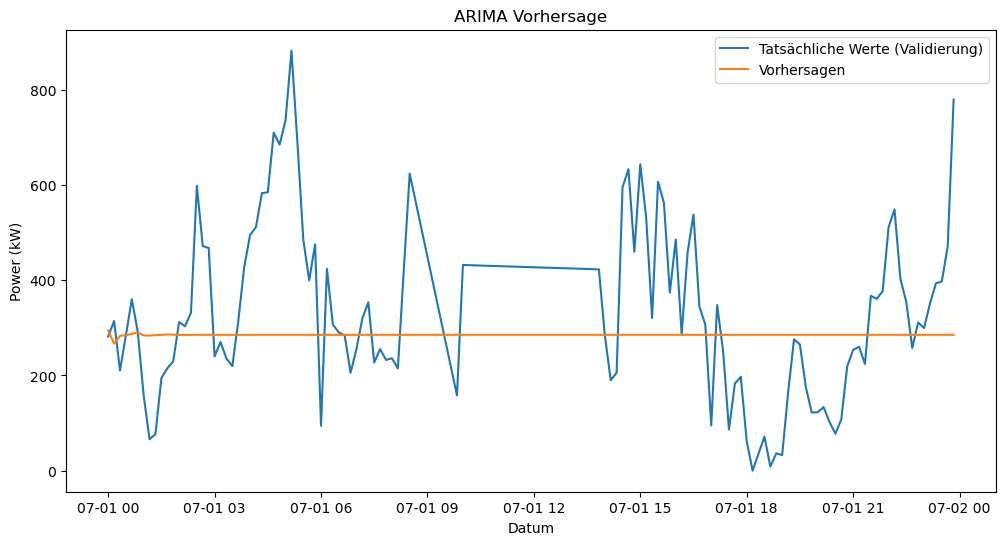

In [39]:
horizon = 144

plt.figure(figsize=(12, 6))
plt.title("ARIMA Vorhersage")
plt.plot(df_val.index[:horizon], df_val["Power (kW)"].iloc[:horizon], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:horizon], forecasts.predicted_mean[:horizon], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

In [40]:
forecasts = []

# Rollierende Vorhersagen
current_train = df_train["Power (kW)"].copy()

for i in range(0, 144, 6):
    # Modell fitten
    model = ARIMA(current_train, order=auto_arima_model.order)
    model_fit = model.fit()

    # Vorhersage für 6 Schritte
    forecast = model_fit.forecast(steps=6)
    forecasts.extend(forecast)

    # Tatsächliche Werte der nächsten 6 Schritte hinzufügen
    actual_values = df_val["Power (kW)"].iloc[i:i + 6]
    current_train = pd.concat([current_train, actual_values])  # Aktualisieren
# Ergebnisse als DataFrame speichern
forecast_results = pd.DataFrame({
    'Forecast': forecasts[:len(df_val["Power (kW)"])],
    'Actual': df_val["Power (kW)"].iloc[:144].values.flatten()
}, index=df_val["Power (kW)"].index[:144])

print(forecast_results)

                       Forecast      Actual
Date and time                              
2020-07-01 00:00:00  303.636116  281.819361
2020-07-01 00:10:00  297.033525  314.220825
2020-07-01 00:20:00  298.757521  210.507291
2020-07-01 00:30:00  297.902176  284.604291
2020-07-01 00:40:00  298.857444  360.124842
...                         ...         ...
2020-07-01 23:10:00  330.232342  350.911439
2020-07-01 23:20:00  328.882695  393.234329
2020-07-01 23:30:00  324.425000  397.382387
2020-07-01 23:40:00  324.094200  471.199436
2020-07-01 23:50:00  324.798155  779.179174

[144 rows x 2 columns]


In [41]:
forecast_results = pd.DataFrame({
    'Forecast': forecasts[:len(df_val["Power (kW)"])],
    'Actual': df_val["Power (kW)"].iloc[:144].values.flatten()
}, index=df_val["Power (kW)"].index[:144])

print(forecast_results)

                       Forecast      Actual
Date and time                              
2020-07-01 00:00:00  303.636116  281.819361
2020-07-01 00:10:00  297.033525  314.220825
2020-07-01 00:20:00  298.757521  210.507291
2020-07-01 00:30:00  297.902176  284.604291
2020-07-01 00:40:00  298.857444  360.124842
...                         ...         ...
2020-07-01 23:10:00  330.232342  350.911439
2020-07-01 23:20:00  328.882695  393.234329
2020-07-01 23:30:00  324.425000  397.382387
2020-07-01 23:40:00  324.094200  471.199436
2020-07-01 23:50:00  324.798155  779.179174

[144 rows x 2 columns]


In [42]:
import pandas as pd
import numpy as np

# Annahme: forecast_results und df_val sind DataFrames mit den entsprechenden Spalten
forecast_values = forecast_results["Forecast"].values
actual_values = df_val["Power (kW)"].values

# Anzahl der Schritte pro Vorhersage
steps_per_forecast = 6

# Aufteilen der Vorhersagen und tatsächlichen Werte in 6er-Gruppen
forecast_groups = np.split(forecast_values, len(forecast_values) // steps_per_forecast)
actual_groups = np.split(actual_values[:len(forecast_values)], len(forecast_values) // steps_per_forecast)

# Funktion zur Berechnung der Metriken für jede Gruppe
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mad = np.median(np.abs(actual - predicted))
    smape = 100 * np.mean(
        np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)
    )
    me = np.mean(actual - predicted)
    return rmse, mad, smape, me

# Metriken für jede Gruppe berechnen
metrics = [calculate_metrics(actual, forecast) for actual, forecast in zip(actual_groups, forecast_groups)]

# Ergebnisse in ein DataFrame umwandeln
metrics_df = pd.DataFrame(metrics, columns=["RMSE", "MAD", "sMAPE (%)", "Bias"])

# Durchschnittswerte aller Gruppen berechnen
average_metrics = metrics_df.mean()

# Ergebnisse ausgeben
print("Durchschnittliche Metriken über alle Gruppen:")
print(average_metrics)


Durchschnittliche Metriken über alle Gruppen:
RMSE         143.614243
MAD          124.676032
sMAPE (%)     44.390009
Bias           6.664530
dtype: float64


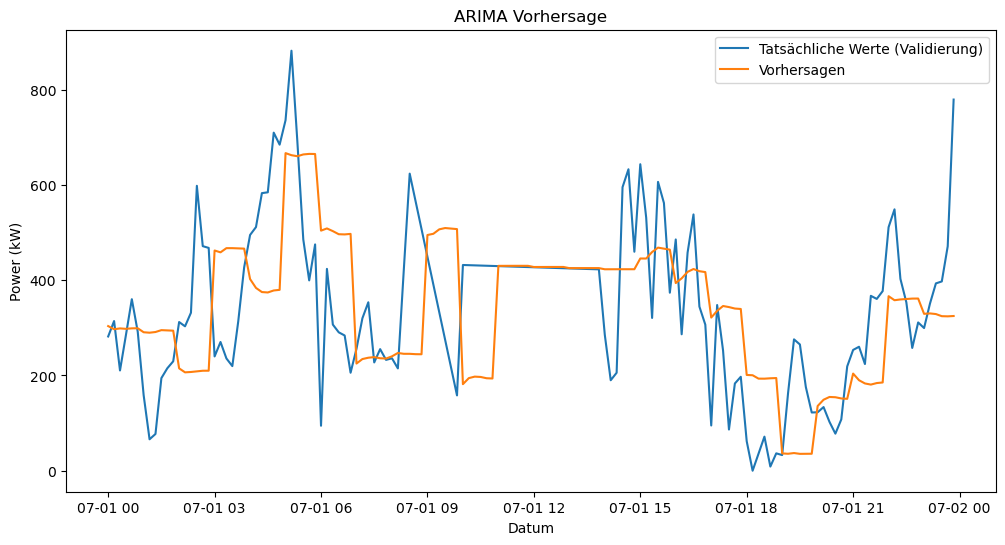

In [43]:
horizon = 144

plt.figure(figsize=(12, 6))
plt.title("ARIMA Vorhersage")
plt.plot(df_val.index[:horizon], df_val["Power (kW)"].iloc[:horizon], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:horizon], forecast_results["Forecast"], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

In [44]:
arima_forecasts = forecast_results["Forecast"]

## SARIMAX Forecast

In [45]:
auto_arima_model.order

(4, 1, 0)

In [46]:
sarima_modell = SARIMAX(df_train["Power (kW)"].iloc[-144:], order=auto_arima_model.order, seasonal_order=(1,1,1,6))

In [47]:
fit = sarima_modell.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20312D+00    |proj g|=  9.99018D-02

At iterate    5    f=  6.15946D+00    |proj g|=  6.49385D-02

At iterate   10    f=  6.13831D+00    |proj g|=  3.47351D-03

At iterate   15    f=  6.13799D+00    |proj g|=  2.92339D-03

At iterate   20    f=  6.10795D+00    |proj g|=  1.20331D-01

At iterate   25    f=  6.07356D+00    |proj g|=  2.84793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   

In [48]:
forecasts = fit.get_forecast(steps=144)

In [49]:
forecasts.predicted_mean

2020-07-01 00:00:00    271.567184
2020-07-01 00:10:00    219.557784
2020-07-01 00:20:00    213.289127
2020-07-01 00:30:00    235.848218
2020-07-01 00:40:00    214.441686
                          ...    
2020-07-01 23:10:00   -735.884296
2020-07-01 23:20:00   -762.021498
2020-07-01 23:30:00   -747.785577
2020-07-01 23:40:00   -765.763089
2020-07-01 23:50:00   -713.584290
Freq: 10min, Name: predicted_mean, Length: 144, dtype: float64

In [50]:
import pandas as pd
import numpy as np

# Annahme: forecast_results und df_val sind DataFrames mit den entsprechenden Spalten
forecast_values = forecasts.predicted_mean
actual_values = df_val["Power (kW)"].iloc[:144].values

# Anzahl der Schritte pro Vorhersage
steps_per_forecast = 6

# Aufteilen der Vorhersagen und tatsächlichen Werte in 6er-Gruppen
forecast_groups = np.split(forecast_values, len(forecast_values) // steps_per_forecast)
actual_groups = np.split(actual_values[:len(forecast_values)], len(forecast_values) // steps_per_forecast)

# Funktion zur Berechnung der Metriken für jede Gruppe
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mad = np.median(np.abs(actual - predicted))
    smape = 100 * np.mean(
        np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)
    )
    me = np.mean(actual - predicted)
    return rmse, mad, smape, me

# Metriken für jede Gruppe berechnen
metrics = [calculate_metrics(actual, forecast) for actual, forecast in zip(actual_groups, forecast_groups)]

# Ergebnisse in ein DataFrame umwandeln
metrics_df = pd.DataFrame(metrics, columns=["RMSE", "MAD", "sMAPE (%)", "Bias"])

# Durchschnittswerte aller Gruppen berechnen
average_metrics = metrics_df.mean()

# Ergebnisse ausgeben
print("Durchschnittliche Metriken über alle Gruppen:")
print(average_metrics)


Durchschnittliche Metriken über alle Gruppen:
RMSE         609.570647
MAD          600.567438
sMAPE (%)    173.206590
Bias         595.240484
dtype: float64


In [51]:
actual_values = df_val["Power (kW)"].iloc[:144]

mae = mean_absolute_error(actual_values, forecasts.predicted_mean)
rmse = root_mean_squared_error(actual_values, forecasts.predicted_mean)

print("Vorhersagen:", forecasts.predicted_mean)
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Vorhersagen: 2020-07-01 00:00:00    271.567184
2020-07-01 00:10:00    219.557784
2020-07-01 00:20:00    213.289127
2020-07-01 00:30:00    235.848218
2020-07-01 00:40:00    214.441686
                          ...    
2020-07-01 23:10:00   -735.884296
2020-07-01 23:20:00   -762.021498
2020-07-01 23:30:00   -747.785577
2020-07-01 23:40:00   -765.763089
2020-07-01 23:50:00   -713.584290
Freq: 10min, Name: predicted_mean, Length: 144, dtype: float64
Tatsächliche Werte: [281.81936111 314.2208252  210.50729065 284.60429061 360.12484233
 291.78225146 158.57059479  65.99496496  77.13671436 194.43927892
 215.03114395 229.68192444 312.14435272 303.14954681 331.66476746
 598.13167877 471.44788361 467.75312653 239.93006134 270.2454567
 235.67829742 219.60883484 313.55501404 426.89199219 494.90466461
 511.47621556 582.74991608 584.48176117 709.71752625 684.50593567
 735.77744751 881.70802066 690.82657182 485.64039307 399.58408833
 475.06632182  94.41724459 423.74570084 306.79590486 290.52557335
 28

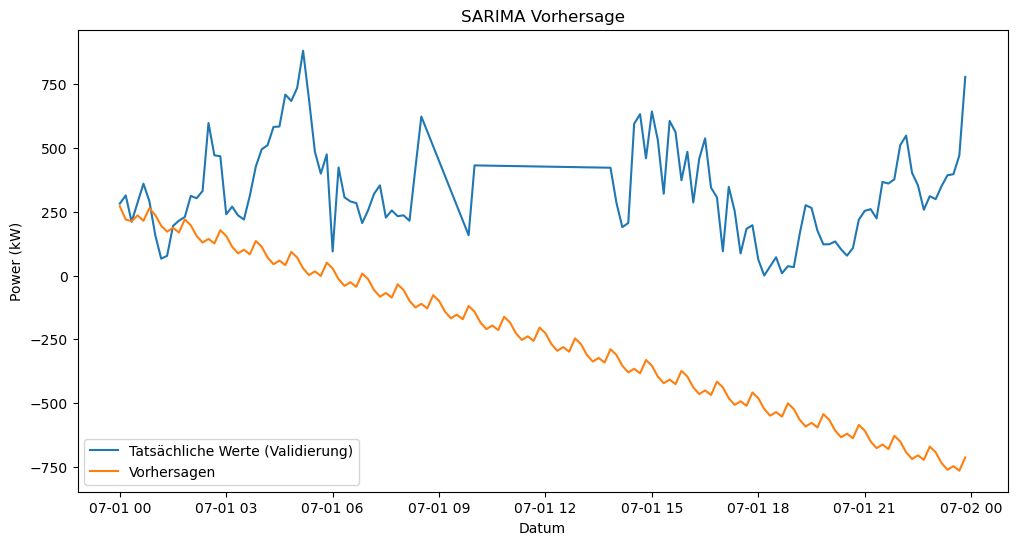

In [52]:
plt.figure(figsize=(12, 6))
plt.title("SARIMA Vorhersage")
plt.plot(df_val.index[:144], df_val["Power (kW)"].iloc[:144], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:144], forecasts.predicted_mean[:144], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

# Prophet

In [53]:
df_prophet = df_train.reset_index()[["Date and time", "Power (kW)"]]
df_prophet.columns = ["ds", "y"]
df_prophet_val = df_val.reset_index()[["Date and time", "Power (kW)"]]
df_prophet_val.columns = ["ds", "y"]

In [54]:
df_prophet

,ds,y
0,2019-07-01 00:00:00,754.911838
1,2019-07-01 00:10:00,902.666745
2,2019-07-01 00:20:00,1004.915256
3,2019-07-01 00:30:00,1059.452505
4,2019-07-01 00:40:00,1206.276666
...,...,...
52699,2020-06-30 23:10:00,179.311019
52700,2020-06-30 23:20:00,210.279492
52701,2020-06-30 23:30:00,321.504546
52702,2020-06-30 23:40:00,273.330340


In [55]:
train_size = 144
forecast_size = 144

In [56]:
train_set = df_prophet
val_set = df_prophet_val

In [57]:
from prophet import Prophet

prophet = Prophet(
    changepoint_prior_scale= 0.01, 
    seasonality_prior_scale= 0.5,
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=False
)

In [58]:
prophet.fit(train_set)

16:38:45 - cmdstanpy - INFO - Chain [1] start processing
16:38:48 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
future = pd.DataFrame({"ds": val_set["ds"].iloc[:144]})

In [60]:
future

,ds
0,2020-07-01 00:00:00
1,2020-07-01 00:10:00
2,2020-07-01 00:20:00
3,2020-07-01 00:30:00
4,2020-07-01 00:40:00
...,...
139,2020-07-01 23:10:00
140,2020-07-01 23:20:00
141,2020-07-01 23:30:00
142,2020-07-01 23:40:00


In [61]:
forecast = prophet.predict(future)

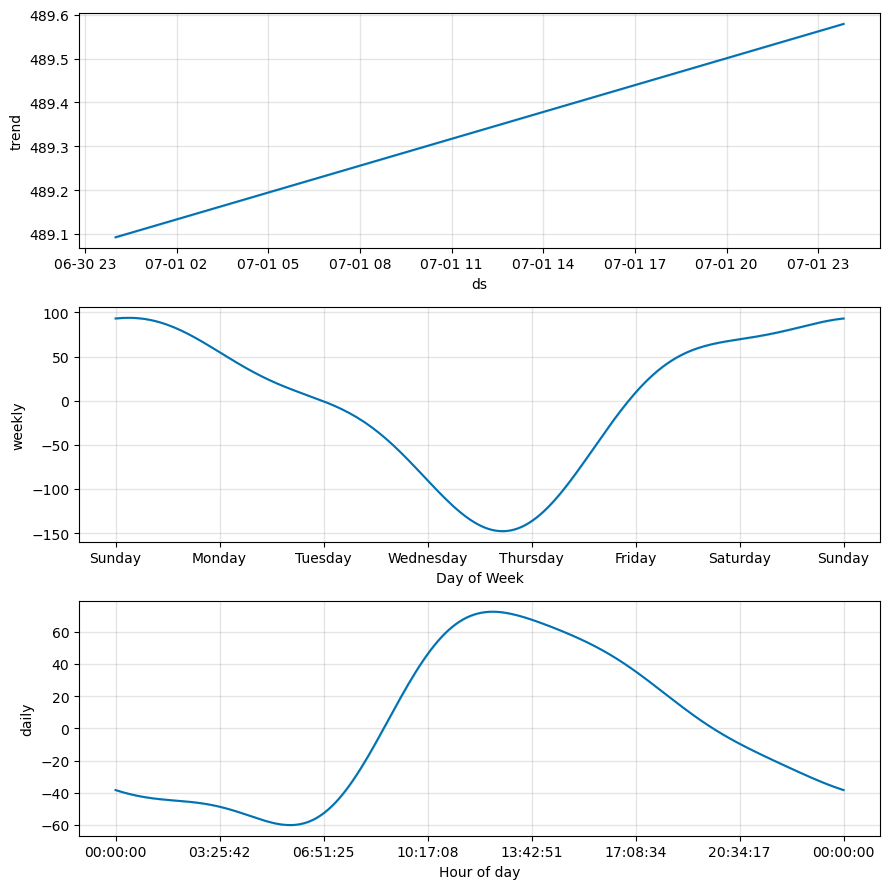

In [62]:
fig = prophet.plot_components(forecast)

In [63]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-07-01 00:00:00,489.092867,-381.292176,1151.751765,489.092867,489.092867,-128.464927,-128.464927,-128.464927,-38.372884,-38.372884,-38.372884,-90.092043,-90.092043,-90.092043,0.0,0.0,0.0,360.627940
1,2020-07-01 00:10:00,489.096266,-367.411819,1174.163416,489.096266,489.096266,-130.297209,-130.297209,-130.297209,-39.337883,-39.337883,-39.337883,-90.959326,-90.959326,-90.959326,0.0,0.0,0.0,358.799057
2,2020-07-01 00:20:00,489.099666,-370.141763,1162.918592,489.099666,489.099666,-132.045146,-132.045146,-132.045146,-40.219423,-40.219423,-40.219423,-91.825723,-91.825723,-91.825723,0.0,0.0,0.0,357.054520
3,2020-07-01 00:30:00,489.103065,-419.587981,1101.809657,489.103065,489.103065,-133.706131,-133.706131,-133.706131,-41.015047,-41.015047,-41.015047,-92.691083,-92.691083,-92.691083,0.0,0.0,0.0,355.396934
4,2020-07-01 00:40:00,489.106464,-415.473322,1106.176350,489.106464,489.106464,-135.279569,-135.279569,-135.279569,-41.724314,-41.724314,-41.724314,-93.555255,-93.555255,-93.555255,0.0,0.0,0.0,353.826896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2020-07-01 23:10:00,489.565390,-419.244935,1067.668792,489.565390,489.565390,-171.415532,-171.415532,-171.415532,-32.489893,-32.489893,-32.489893,-138.925639,-138.925639,-138.925639,0.0,0.0,0.0,318.149858
140,2020-07-01 23:20:00,489.568789,-442.645122,1031.822524,489.568789,489.568789,-172.212578,-172.212578,-172.212578,-33.783616,-33.783616,-33.783616,-138.428961,-138.428961,-138.428961,0.0,0.0,0.0,317.356212
141,2020-07-01 23:30:00,489.572189,-458.027202,1095.503805,489.572189,489.572189,-172.945713,-172.945713,-172.945713,-35.026704,-35.026704,-35.026704,-137.919009,-137.919009,-137.919009,0.0,0.0,0.0,316.626475
142,2020-07-01 23:40:00,489.575588,-439.609737,1042.854098,489.575588,489.575588,-173.606820,-173.606820,-173.606820,-36.210967,-36.210967,-36.210967,-137.395853,-137.395853,-137.395853,0.0,0.0,0.0,315.968768


In [64]:
actuals = val_set['y'].iloc[:144]
predictions = forecast['yhat'].iloc[:144]

prophet_mse = mean_squared_error(actuals, predictions)
prophet_mae = mean_absolute_error(actuals, predictions)
prophet_rmse = root_mean_squared_error(actuals, predictions)

print(f'Mean Squared Error: {prophet_mse}')
print(f'Mean Absolute Error: {prophet_mae}')
print(f'Root Mean Squared Error: {prophet_rmse}')

Mean Squared Error: 28899.716813078427
Mean Absolute Error: 127.47282806257107
Root Mean Squared Error: 169.9991670952491


In [65]:
predictions

0      360.627940
1      358.799057
2      357.054520
3      355.396934
4      353.826896
          ...    
139    318.149858
140    317.356212
141    316.626475
142    315.968768
143    315.390757
Name: yhat, Length: 144, dtype: float64

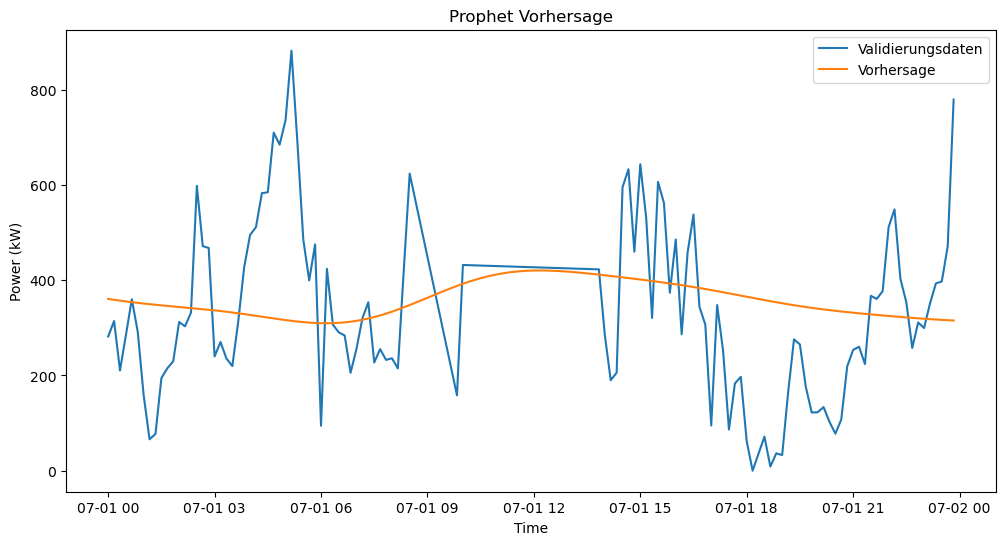

In [66]:
plt.figure(figsize=(12, 6))
plt.title(label="Prophet Vorhersage")
plt.plot(val_set['ds'].iloc[:144], val_set['y'].iloc[:144], label="Validierungsdaten")
plt.plot(val_set['ds'].iloc[:144], predictions.iloc[:144], label="Vorhersage")
plt.ylabel("Power (kW)")
plt.xlabel("Time")
plt.legend()
plt.show()

In [67]:
import pandas as pd

# Liste für Vorhersagen
forecasts = []

# Initiale Trainingsdaten
current_train = train_set[["ds", "y"]].iloc[-144:].copy()

for i in range(0, 144, 6):
    # Prophet-Modell initialisieren
    model = Prophet(
        changepoint_prior_scale= 0.01,
        seasonality_prior_scale= 0.5,
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=False
    )
    model.fit(current_train)

    # DataFrame für Vorhersagen erstellen
    future = pd.DataFrame({
        "ds": val_set["ds"].iloc[i:i + 6]
    })

    # Vorhersage für 6 Schritte
    forecast = model.predict(future)
    forecasts.extend(forecast["yhat"].values)

    # Tatsächliche Werte der nächsten 6 Schritte hinzufügen
    actual_values = val_set[["ds", "y"]].iloc[i:i + 6]
    current_train = pd.concat([current_train, actual_values])  # Aktualisieren

# Ergebnisse als DataFrame speichern
forecast_results = pd.DataFrame({
    "Forecast": forecasts[:len(val_set["y"])],
    "Actual": val_set["y"].iloc[:144].values.flatten()
}, index=val_set["ds"].iloc[:144])

print(forecast_results)

16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:49 - cmdstanpy - INFO - Chain [1] done processing
16:38:50 - cmdstanpy - INFO - Chain [1] start processing
16:38:50 - cmdstanpy - INFO - Chain [1]

                       Forecast      Actual
ds                                         
2020-07-01 00:00:00  174.301503  281.819361
2020-07-01 00:10:00  145.649847  314.220825
2020-07-01 00:20:00  114.031488  210.507291
2020-07-01 00:30:00   79.853046  284.604291
2020-07-01 00:40:00   43.588834  360.124842
...                         ...         ...
2020-07-01 23:10:00  359.528579  350.911439
2020-07-01 23:20:00  354.756743  393.234329
2020-07-01 23:30:00  347.637187  397.382387
2020-07-01 23:40:00  338.364427  471.199436
2020-07-01 23:50:00  327.181434  779.179174

[144 rows x 2 columns]


In [68]:
import pandas as pd
import numpy as np

# Annahme: forecast_results und df_val sind DataFrames mit den entsprechenden Spalten
forecast_values = forecast_results["Forecast"].values
actual_values = df_val["Power (kW)"].values

# Anzahl der Schritte pro Vorhersage
steps_per_forecast = 6

# Aufteilen der Vorhersagen und tatsächlichen Werte in 6er-Gruppen
forecast_groups = np.split(forecast_values, len(forecast_values) // steps_per_forecast)
actual_groups = np.split(actual_values[:len(forecast_values)], len(forecast_values) // steps_per_forecast)

# Funktion zur Berechnung der Metriken für jede Gruppe
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mad = np.median(np.abs(actual - predicted))
    smape = 100 * np.mean(
        np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)
    )
    me = np.mean(actual - predicted)
    return rmse, mad, smape, me

# Metriken für jede Gruppe berechnen
metrics = [calculate_metrics(actual, forecast) for actual, forecast in zip(actual_groups, forecast_groups)]

# Ergebnisse in ein DataFrame umwandeln
metrics_df = pd.DataFrame(metrics, columns=["RMSE", "MAD", "sMAPE (%)", "Bias"])

# Durchschnittswerte aller Gruppen berechnen
average_metrics = metrics_df.mean()

# Ergebnisse ausgeben
print("Durchschnittliche Metriken über alle Gruppen:")
print(average_metrics)


Durchschnittliche Metriken über alle Gruppen:
RMSE         190.926585
MAD          165.184354
sMAPE (%)     68.786389
Bias          80.808286
dtype: float64


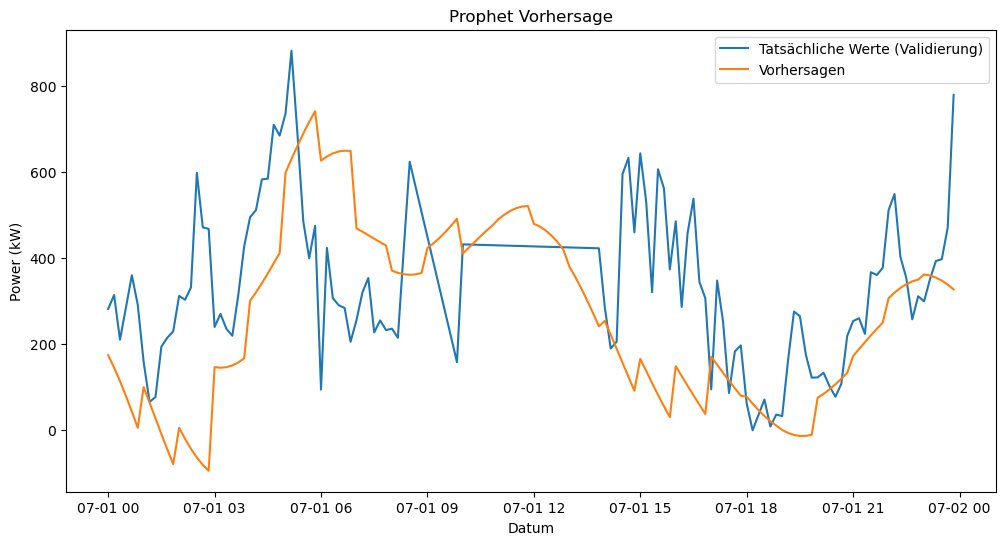

In [69]:
horizon = 144

plt.figure(figsize=(12, 6))
plt.title("Prophet Vorhersage")
plt.plot(df_val.index[:horizon], df_val["Power (kW)"].iloc[:horizon], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:horizon], forecast_results["Forecast"], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

In [70]:
prophet_forecasts = forecast_results["Forecast"]

# ML

In [71]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear

    return df

In [72]:
def add_lags(df):
    # Sicherstellen, dass die Zielspalte existiert
    if "Power (kW)" not in df.columns:
        raise ValueError("Die Spalte 'Power (kW)' muss im DataFrame enthalten sein.")
    
    # Lag-Features iterativ hinzufügen
    for lag_steps in [6, 12, 18]:
        lag_column = f"lag_{lag_steps}"  # Eindeutiger Name für jede Lag-Spalte
        df[lag_column] = df["Power (kW)"].shift(lag_steps)  # Werte verschieben
    
    return df 

In [73]:
train = create_features(df_train)
val = create_features(df_val)

trainval = pd.concat([train, val])

In [74]:
train.columns
trainval = add_lags(trainval)

In [75]:
print(len(train))
print(len(val))

52704
52560


In [76]:
train = trainval[:52704]
val = trainval[52704:]


In [77]:
train.drop(columns=['Density adjusted wind speed (m/s)', 'Wind direction (°)',
       'Nacelle position (°)', 'Wind speed (m/s)'])
val.drop(columns=['Density adjusted wind speed (m/s)', 'Wind direction (°)',
       'Nacelle position (°)', 'Wind speed (m/s)'])


,Power (kW),MA_24h,hour,dayofweek,month,year,dayofyear,lag_6,lag_12,lag_18
Date and time,,,,,,,,,,
2020-07-01 00:00:00,281.819361,NaN,0,2,7,2020,183,215.845830,205.833358,436.534483
2020-07-01 00:10:00,314.220825,NaN,0,2,7,2020,183,179.311019,168.184347,548.468263
2020-07-01 00:20:00,210.507291,NaN,0,2,7,2020,183,210.279492,84.138816,331.927261
2020-07-01 00:30:00,284.604291,NaN,0,2,7,2020,183,321.504546,252.472354,235.431866
2020-07-01 00:40:00,360.124842,NaN,0,2,7,2020,183,273.330340,410.632492,221.976776
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 23:10:00,50.639999,NaN,23,2,6,2021,181,0.000000,0.000000,0.000000
2021-06-30 23:20:00,97.330002,NaN,23,2,6,2021,181,0.000000,0.000000,0.000000
2021-06-30 23:30:00,73.730003,NaN,23,2,6,2021,181,0.000000,0.000000,0.000000


In [78]:
FEATURES = ['hour', 'dayofweek', 'month',
       'year', 'dayofyear', 'lag_6', 'lag_12', 'lag_18']
TARGET = ['Power (kW)']


In [79]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_val = val[FEATURES]
y_val = val[TARGET]


## XGBoost

In [80]:
with open('xgb_model.pkl', 'rb') as file:
    xgb = pickle.load(file)

In [81]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.05,
    n_estimators=100,
    gamma=0.5,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=46.41588833612773,
    reg_lambda=2.154434690031882,
    random_state=42
)

In [82]:
xgb_fit = xgb.fit(X_train, y_train,
        verbose=True)

### Feature Importances

<Axes: title={'center': 'Feature Importance'}>

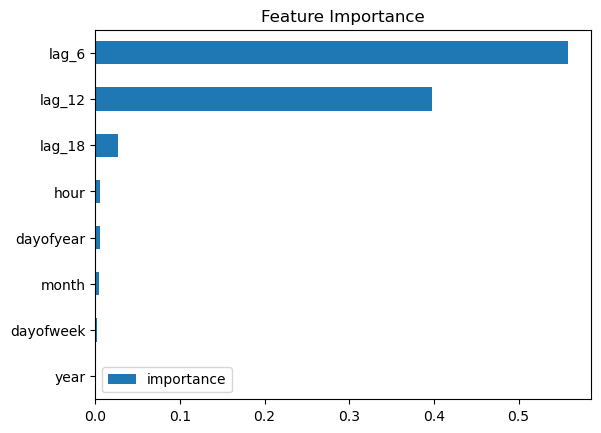

In [83]:
## Feature Importance
fi = pd.DataFrame(data=xgb_fit.feature_importances_, index=xgb_fit.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
## Forecast on Validationset


In [84]:

val['prediction'] = xgb_fit.predict(X_val)
df_val.merge(val[['prediction']], how='left', left_index=True, right_index=True)


,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Density adjusted wind speed (m/s),prediction
Date and time,,,,,,
2020-07-01 00:00:00,5.160345,223.299645,210.185474,281.819361,5.110880,259.894653
2020-07-01 00:10:00,5.494860,225.088881,225.560730,314.220825,5.442110,221.194717
2020-07-01 00:20:00,5.021182,234.076822,225.560730,210.507291,4.973395,222.529846
2020-07-01 00:30:00,5.238322,241.270169,225.560730,284.604291,5.188159,322.416901
2020-07-01 00:40:00,5.862007,227.233162,225.560730,360.124842,5.805543,331.118652
...,...,...,...,...,...,...
2021-06-30 23:10:00,3.840000,39.950001,34.590000,50.639999,3.615210,43.271854
2021-06-30 23:20:00,4.130000,39.709999,34.590000,97.330002,3.615210,43.271854
2021-06-30 23:30:00,3.780000,42.220001,34.590000,73.730003,3.615210,43.271854


In [85]:
import pandas as pd
import numpy as np

# Annahme: forecast_results und df_val sind DataFrames mit den entsprechenden Spalten
forecast_values = val['prediction'].values
actual_values = df_val["Power (kW)"].values

# Anzahl der Schritte pro Vorhersage
steps_per_forecast = 6

# Aufteilen der Vorhersagen und tatsächlichen Werte in 6er-Gruppen
forecast_groups = np.split(forecast_values, len(forecast_values) // steps_per_forecast)
actual_groups = np.split(actual_values[:len(forecast_values)], len(forecast_values) // steps_per_forecast)

# Funktion zur Berechnung der Metriken für jede Gruppe
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mad = np.median(np.abs(actual - predicted))
    smape = 100 * np.mean(
        np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)
    )
    me = np.mean(actual - predicted)
    return rmse, mad, smape, me

# Metriken für jede Gruppe berechnen
metrics = [calculate_metrics(actual, forecast) for actual, forecast in zip(actual_groups, forecast_groups)]

# Ergebnisse in ein DataFrame umwandeln
metrics_df = pd.DataFrame(metrics, columns=["RMSE", "MAD", "sMAPE (%)", "Bias"])

# Durchschnittswerte aller Gruppen berechnen
average_metrics = metrics_df.mean()

# Ergebnisse ausgeben
print("Durchschnittliche Metriken über alle Gruppen:")
print(average_metrics)


Durchschnittliche Metriken über alle Gruppen:
RMSE         201.355202
MAD          169.831130
sMAPE (%)     63.511222
Bias          -4.203389
dtype: float64


In [86]:
actual_values = df_val["Power (kW)"].iloc[:144]

mae = mean_absolute_error(actual_values, val['prediction'].iloc[:144])
rmse = root_mean_squared_error(actual_values, val['prediction'].iloc[:144])

print("Vorhersagen:", val['prediction'].iloc[:144])
print("Tatsächliche Werte:", actual_values.values)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Vorhersagen: Date and time
2020-07-01 00:00:00    259.894653
2020-07-01 00:10:00    221.194717
2020-07-01 00:20:00    222.529846
2020-07-01 00:30:00    322.416901
2020-07-01 00:40:00    331.118652
                          ...    
2020-07-01 23:10:00    484.974243
2020-07-01 23:20:00    378.864746
2020-07-01 23:30:00    368.088165
2020-07-01 23:40:00    278.592407
2020-07-01 23:50:00    363.367737
Name: prediction, Length: 144, dtype: float32
Tatsächliche Werte: [281.81936111 314.2208252  210.50729065 284.60429061 360.12484233
 291.78225146 158.57059479  65.99496496  77.13671436 194.43927892
 215.03114395 229.68192444 312.14435272 303.14954681 331.66476746
 598.13167877 471.44788361 467.75312653 239.93006134 270.2454567
 235.67829742 219.60883484 313.55501404 426.89199219 494.90466461
 511.47621556 582.74991608 584.48176117 709.71752625 684.50593567
 735.77744751 881.70802066 690.82657182 485.64039307 399.58408833
 475.06632182  94.41724459 423.74570084 306.79590486 290.52557335
 283.9

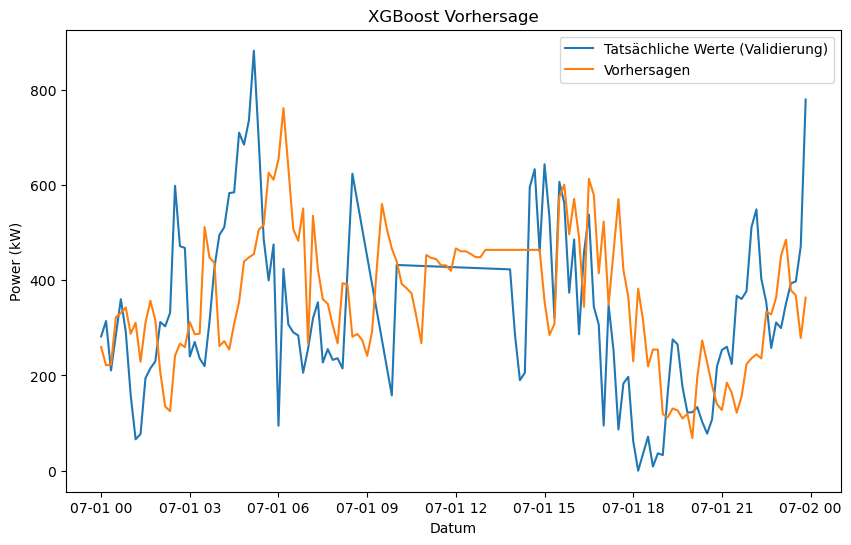

In [87]:
horizon = 144

plt.figure(figsize=(10, 6))
plt.title("XGBoost Vorhersage")
plt.plot(df_val.index[:horizon], df_val["Power (kW)"].iloc[:horizon], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:horizon], val['prediction'].iloc[:horizon], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

In [88]:
xgb_forecasts = val['prediction'].iloc[:144]

## Random Forest

In [89]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Das Modell ist bereit zur Verwendung (z. B. fit() auf Trainingsdaten)

In [90]:
rf.fit(X_train.iloc[:], y_train.iloc[:])

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=200, random_state=42)

In [91]:
print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)

Trainingsdaten: (52704, 8)
Validierungsdaten: (52560, 8)


In [92]:
val['prediction'] = rf.predict(X_val)
df_val.merge(val[['prediction']], how='left', left_index=True, right_index=True)

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Density adjusted wind speed (m/s),prediction
Date and time,,,,,,
2020-07-01 00:00:00,5.160345,223.299645,210.185474,281.819361,5.110880,229.567825
2020-07-01 00:10:00,5.494860,225.088881,225.560730,314.220825,5.442110,209.345505
2020-07-01 00:20:00,5.021182,234.076822,225.560730,210.507291,4.973395,212.714179
2020-07-01 00:30:00,5.238322,241.270169,225.560730,284.604291,5.188159,300.534056
2020-07-01 00:40:00,5.862007,227.233162,225.560730,360.124842,5.805543,299.767112
...,...,...,...,...,...,...
2021-06-30 23:10:00,3.840000,39.950001,34.590000,50.639999,3.615210,54.425238
2021-06-30 23:20:00,4.130000,39.709999,34.590000,97.330002,3.615210,54.425238
2021-06-30 23:30:00,3.780000,42.220001,34.590000,73.730003,3.615210,54.425238


In [93]:
import pandas as pd
import numpy as np

# Annahme: forecast_results und df_val sind DataFrames mit den entsprechenden Spalten
forecast_values = val['prediction'].values
actual_values = df_val["Power (kW)"].values

# Anzahl der Schritte pro Vorhersage
steps_per_forecast = 6

# Aufteilen der Vorhersagen und tatsächlichen Werte in 6er-Gruppen
forecast_groups = np.split(forecast_values, len(forecast_values) // steps_per_forecast)
actual_groups = np.split(actual_values[:len(forecast_values)], len(forecast_values) // steps_per_forecast)

# Funktion zur Berechnung der Metriken für jede Gruppe
def calculate_metrics(actual, predicted):
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    mad = np.median(np.abs(actual - predicted))
    smape = 100 * np.mean(
        np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) / 2)
    )
    me = np.mean(actual - predicted)
    return rmse, mad, smape, me

# Metriken für jede Gruppe berechnen
metrics = [calculate_metrics(actual, forecast) for actual, forecast in zip(actual_groups, forecast_groups)]

# Ergebnisse in ein DataFrame umwandeln
metrics_df = pd.DataFrame(metrics, columns=["RMSE", "MAD", "sMAPE (%)", "Bias"])

# Durchschnittswerte aller Gruppen berechnen
average_metrics = metrics_df.mean()

# Ergebnisse ausgeben
print("Durchschnittliche Metriken über alle Gruppen:")
print(average_metrics)


Durchschnittliche Metriken über alle Gruppen:
RMSE         208.215343
MAD          178.068624
sMAPE (%)     64.349580
Bias         -11.178386
dtype: float64


In [94]:

rmse = np.sqrt(np.mean((actual_values - val['prediction']) ** 2))

# Berechnung von MAD
mad = np.median(np.abs(actual_values - val['prediction']))

# Berechnung von sMAPE
smape = 100 * np.mean(
    np.abs(actual_values - val['prediction']) / ((np.abs(actual_values) + np.abs(val['prediction'])) / 2)
)
me = np.mean(actual_values - val['prediction'])

# Ergebnisse ausgeben
print("RMSE:", rmse)
print("MAD:", mad)
print("sMAPE:", smape, "%")
print("ME:", me)

RMSE: 261.36996989631376
MAD: 127.227071551417
sMAPE: 64.34957983012501 %
ME: -11.178386141713457


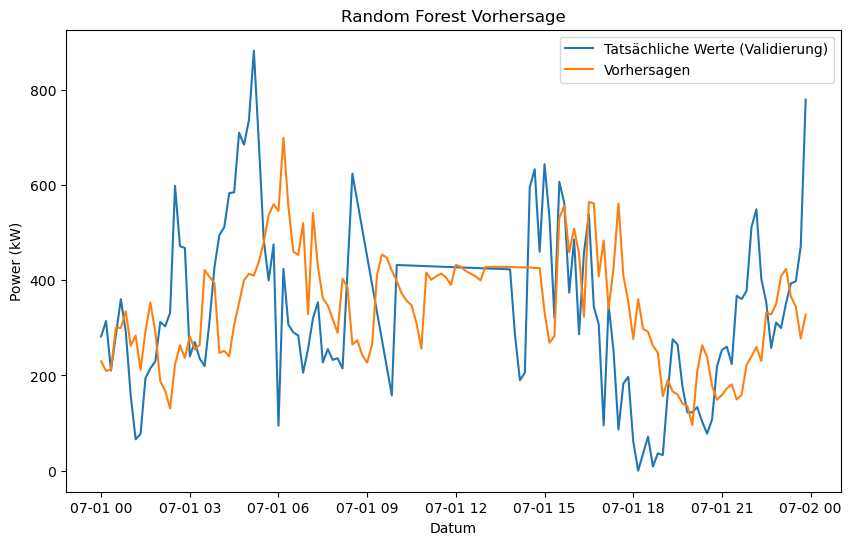

In [95]:
horizon = 144

plt.figure(figsize=(10, 6))
plt.title("Random Forest Vorhersage")
plt.plot(df_val.index[:horizon], df_val["Power (kW)"].iloc[:horizon], label="Tatsächliche Werte (Validierung)")
plt.plot(df_val.index[:horizon], val['prediction'].iloc[:horizon], label="Vorhersagen")
plt.ylabel("Power (kW)")
plt.xlabel("Datum")
plt.legend()
plt.show()

In [96]:
rf_forecasts = val['prediction'].iloc[:144]

In [98]:
print(df_val.index[start:horizon][xticks_positions])  # Prüfen, ob die Labels existieren

DatetimeIndex(['2020-07-01 00:00:00', '2020-07-01 02:20:00',
               '2020-07-01 04:40:00', '2020-07-01 07:00:00',
               '2020-07-01 09:20:00', '2020-07-01 11:40:00',
               '2020-07-01 14:00:00', '2020-07-01 16:20:00',
               '2020-07-01 18:40:00', '2020-07-01 21:00:00',
               '2020-07-01 23:20:00'],
              dtype='datetime64[ns]', name='Date and time', freq=None)


range(0, 144, 14)


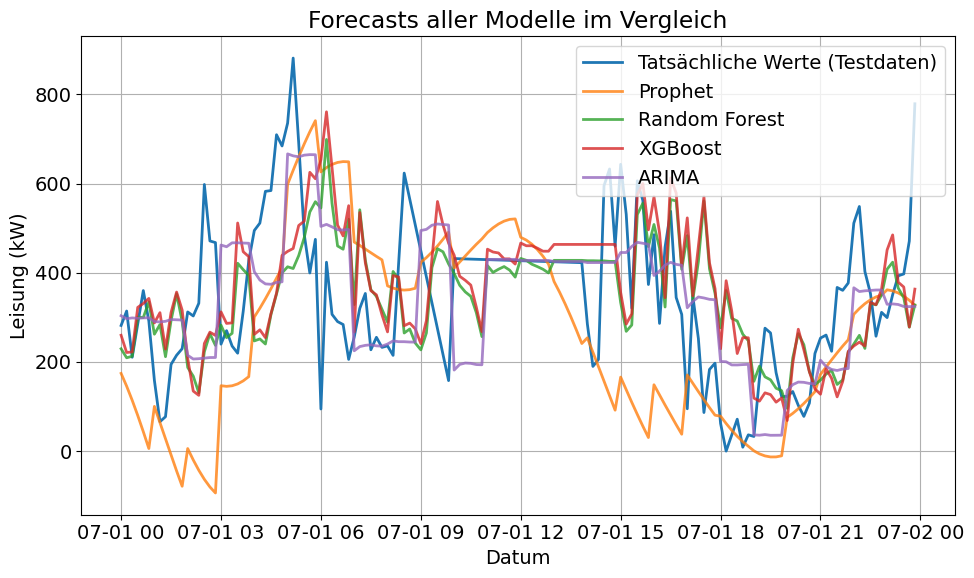

In [111]:
horizon = 144
start = 0

xticks_positions = range(0, horizon, horizon // 10)  # Jeder zweite Wert oder nach Bedarf
print(xticks_positions)


plt.figure(figsize=(10, 6))
plt.title("Forecasts aller Modelle im Vergleich")
plt.plot(df_val.index[start:horizon], df_val["Power (kW)"].iloc[:144], label="Tatsächliche Werte (Testdaten)", linewidth=2)
plt.plot(df_val.index[start:horizon], prophet_forecasts[start:horizon], label="Prophet", linewidth=2, alpha=0.8)
plt.plot(df_val.index[start:horizon], rf_forecasts[start:horizon], label="Random Forest", linewidth=2, alpha=0.8)
plt.plot(df_val.index[start:horizon], xgb_forecasts[start:horizon], label="XGBoost", linewidth=2, alpha=0.8)
plt.plot(df_val.index[start:horizon], arima_forecasts[start:horizon], label="ARIMA", linewidth=2, alpha=0.8)
plt.ylabel("Leisung (kW)")
plt.xlabel("Datum")
#plt.xticks(xticks_positions)  # xticks hinzufügen
plt.rcParams.update({'font.size': 14})
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

range(0, 144, 14)


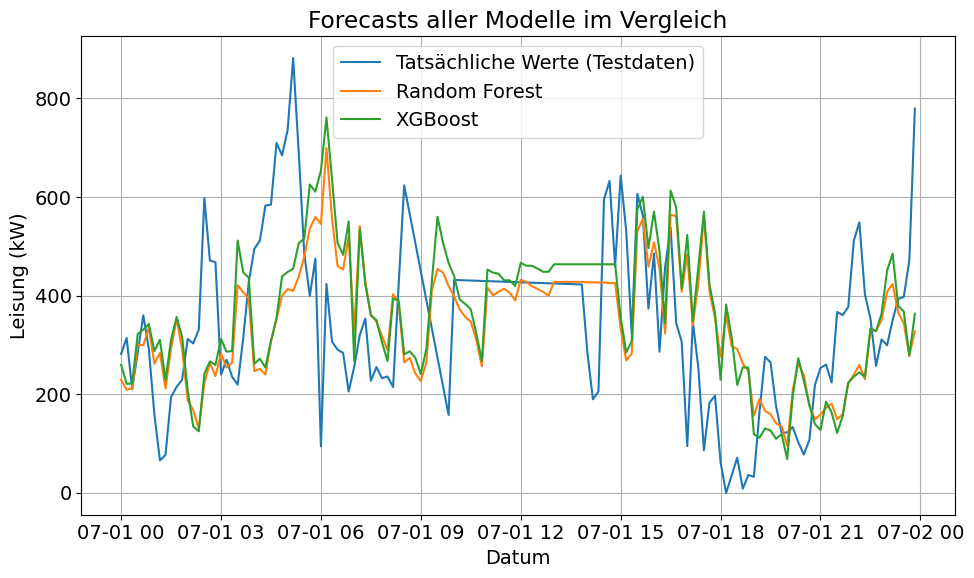

In [112]:
horizon = 144
start = 0

xticks_positions = range(0, horizon, horizon // 10)  # Jeder zweite Wert oder nach Bedarf
print(xticks_positions)


plt.figure(figsize=(10, 6))
plt.title("Forecasts von Random Forest und XGBoost im Vergleich")
plt.plot(df_val.index[start:horizon], df_val["Power (kW)"].iloc[:144], label="Tatsächliche Werte (Testdaten)",)
plt.plot(df_val.index[start:horizon], rf_forecasts[start:horizon], label="Random Forest",)
plt.plot(df_val.index[start:horizon], xgb_forecasts[start:horizon], label="XGBoost",)
plt.ylabel("Leisung (kW)")
plt.xlabel("Datum")
#plt.xticks(xticks_positions)  # xticks hinzufügen
plt.rcParams.update({'font.size': 14})
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()